# Multiprocessing
### Here is the test
- end goal is a FunctionBundle of different gaussians
- each point takes some artificial time to compute
- printing at every point prefixed by the process name/number
- start with 2 cores, go to 4

### Update
Success!

Some notes
- I couldn't get Pool to work
- Pool is meant for huge loops. We don't use those with MEEP for smallish sweeps < 100
- Get a shared resource (list, dict, etc.) through the Manager class
- It is possible to maintain ordering by passing index as an argument (list) or some key (dict)
- You can have each one do liveplot
    - strangely, you must pass a common figure reference, but the curves don't show up together

In [33]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import time

from multiprocessing import Pool, Manager, Process

from lightlab.util import io
from lightlab.util.data import Spectrum, FunctionBundle, MeasuredFunction

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
io.fileDir = io.dataHome / 'multiproc'

In [35]:
x_basis = np.linspace(0, 1, 100)
def gaussian(x, mu, sigma, sleep=0):
    vals = np.zeros(len(x))  # x must have length
    for i in range(len(x)):
        vals[i] = np.exp(-(x[i] - mu) ** 2 / (2 * sigma ** 2))
        if sleep > 0:
            t0 = time.time()
            while time.time() - t0 < sleep:
                _ = time.time() ** 15  # Takes a lot of resources
                time.sleep(.001)
    return vals

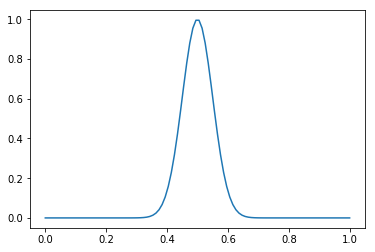

In [36]:
# Basic function check
g1 = lambda x: gaussian(x, .5, .05, .01)
plt.plot(x_basis, g1(x_basis))

In [48]:
# This doesn't work
work = ([0, .6], [1, .5], [2, .3], [3, .4], [4, .62], [5, .52], [6, .32], [7, .42])

outputs = [None] * len(work)
def work_log(work_data):
    global outputs
    print(" Process %s waiting %s seconds" % (work_data[0], work_data[1]*len(x_basis)/10))
#     t0 = time.time()
#     while time.time() - t0 < work_data[1]*10:
#         _ = time.time() ** 15
#         time.sleep(.001)
    this_g = lambda x: gaussian(x, work_data[1], .05, work_data[1]/100)
    values = this_g(x_basis)
#     outputs.append(MeasuredFunction(x_basis, values))
    outputs[work_data[0]] = values
    print(" Process %s Finished." % work_data[0])
#     return outputs


def pool_handler():
    p = Pool(2)
    p.map(work_log, work)
    
pool_handler()

FunctionBundle(outputs).simplePlot()

BrokenPipeError: [Errno 32] Broken pipe

Start 0
Start 1
Start 2
Start 3
Start 4
Start 5
Start 6
Start 7
End 2
End 6
End 3
End 7
End 1
End 5
End 0
Joined <Process(Process-155, stopped)>
Joined <Process(Process-156, stopped)>
Joined <Process(Process-157, stopped)>
Joined <Process(Process-158, stopped)>
End 4
Joined <Process(Process-159, stopped)>
Joined <Process(Process-160, stopped)>
Joined <Process(Process-161, stopped)>
Joined <Process(Process-162, stopped)>
[<lightlab.util.data.one_dim.MeasuredFunction object at 0x11bc3e208>, <lightlab.util.data.one_dim.MeasuredFunction object at 0x11bc3ecf8>, <lightlab.util.data.one_dim.MeasuredFunction object at 0x11bc3e550>, <lightlab.util.data.one_dim.MeasuredFunction object at 0x11bc3ec50>, <lightlab.util.data.one_dim.MeasuredFunction object at 0x11bc3e6a0>, <lightlab.util.data.one_dim.MeasuredFunction object at 0x11bc3e470>, <lightlab.util.data.one_dim.MeasuredFunction object at 0x11bc3ef60>, <lightlab.util.data.one_dim.MeasuredFunction object at 0x11bc3e940>]


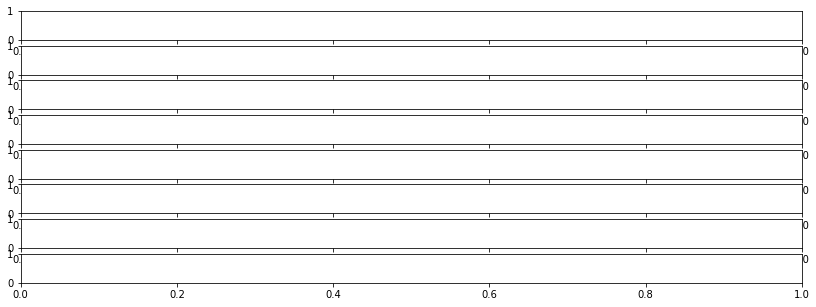

In [63]:
# Try again
work = ([0, .6], [1, .5], [2, .3], [3, .4], [4, .62], [5, .52], [6, .32], [7, .42])

fi, ax = plt.subplots(nrows=8, figsize=(14,5))
def dothing(L, work_data):  # the managed list `L` passed explicitly.
    i, v = work_data
    print('Start', i)
    this_g = lambda x: gaussian(x, v, .05, v/10)
    values = this_g(x_basis)
#     ax[i].plot(values)  # they do not necessarily plot in order
#     display.clear_output(wait=True)
#     display.display(fi)
    
    L[i] = MeasuredFunction(x_basis, values)
    print('End', i)
    
with Manager() as manager:
    L = manager.list(range(8))  # <-- can be shared between processes.
    processes = []
    for i in range(8):
        p = Process(target=dothing, args=(L, work[i]))  # Passing the list
        p.start()
        processes.append(p)
    for p in processes:
        p.join()
        print('Joined', p)
    print(L)
    Ll = list(L)
# FunctionBundle(Ll).simplePlot()